In [1]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

is_outlier = sod_core_dataset.is_outlier

maindir = os.path.abspath(os.path.join(os.getcwd(), '..',
                                       'evaluations/results/eval.allset_train_test.iforest.yaml/evalreports/'))
assert os.path.isdir(maindir)

# THIS ASSUMES YOU ALREADY CREATED THE EVALUATIIN AGGREGATION. SEE AGGREGAT.EVALUATIONS
path = os.path.join(maindir, 'evaluation.all.hdf')
print()
print('READING "%s"' % path)
dfr = pd.read_hdf(path)
print('Columns:\n' + str(dfr.columns.tolist()))

path_auc = os.path.join(maindir, 'evaluation.auc.all.hdf')
print()
print('READING "%s"' % path_auc)
dfr_auc = pd.read_hdf(path_auc)
print('Columns:\n' + str(dfr_auc.columns.tolist()))

# define the classes of interest (see sod code allset_test)
class_inlier = sod_core_dataset.allset_test.classnames[0] # 'ok' 
class_outlier = sod_core_dataset.allset_test.classnames[1] #'outl. (wrong inv)'
class_me_unknown = sod_core_dataset.allset_test.classnames[2]  # 'unlabeled (Me unknown)'

sel_inlier = sod_core_dataset.allset_test.class_selector[class_inlier]
sel_outlier = sod_core_dataset.allset_test.class_selector[class_outlier]
sel_me_unknown = sod_core_dataset.allset_test.class_selector[class_me_unknown]


READING "/Users/riccardo/work/gfz/projects/sources/python/sod/sod/evaluations/results/eval.allset_train_test.iforest.yaml/evalreports/evaluation.all.hdf"
Columns:
['% rec.', 'Mean log_loss', 'behaviour', 'classname', 'clf', 'contamination', 'features', 'max_samples', 'n_estimators']

READING "/Users/riccardo/work/gfz/projects/sources/python/sod/sod/evaluations/results/eval.allset_train_test.iforest.yaml/evalreports/evaluation.auc.all.hdf"
Columns:
['auc', 'behaviour', 'best_thres', 'best_thres_tnr', 'best_thres_tpr', 'classifier', 'contamination', 'features', 'max_samples', 'n_estimators']


In [2]:
# dfr contains the evaluation step with the log losses, dfr_auc with the sucs.
# create an eval dataframe with only the relevant data

hyperparams = ['features', 'n_estimators', 'max_samples', 'contamination', 'behaviour']
data = {}
df_group = dfr.groupby(hyperparams)
dfauc_group = dfr_auc.groupby(hyperparams)
for hpvalues, df in dfr.groupby(hyperparams):
    df_inl = df[df.classname == class_inlier]  # or df[df.classname=='ok']
    df_outl = df[df.classname == class_outlier]  # or df[df.classname=='outl. (wrong inv)']
    # df_auc_ = dfauc_group[hpvalues]
    assert len(df_inl) == 1
    assert len(df_outl) == 1
    # assert len(df_auc_) == 1
    data[hpvalues] = {
        'mean_log loss inliers': df_inl['Mean log_loss'].values[0],
        'mean log loss outliers': df_outl['Mean log_loss'].values[0],
        'features': hpvalues[0],
        'n_estimators': hpvalues[1],
        'max_samples': hpvalues[2],
    }
for hpvalues, df in dfr_auc.groupby(hyperparams):
    assert len(df) == 1
    data[hpvalues].update({
        'auc': df['auc'].values[0],
        'best_thres': df['best_thres'].values[0],
        'best_thres_tnr': df['best_thres_tnr'].values[0],
        'best_thres_tpr': df['best_thres_tpr'].values[0],
    })

eval_df = pd.DataFrame(list(data.values()))
# here we calculate actually (tpr+tnr)/2, for accuracy we should multiply by class instance but the 
# classes are balanced:
eval_df['best_thres_mean recall'] = 0.5 * (eval_df['best_thres_tnr'] + eval_df['best_thres_tpr'])
# eval_df = pd.merge(dfr,dfr_auc,on=['features', 'n_estimators', 'max_samples', 'contamination', 'behaviour'], how = 'left')

print()
print(eval_df[:5])
print()
print(dfr[:5])
print()
print(dfr_auc[:5])



        auc  best_thres  best_thres_tnr  best_thres_tpr    features  \
0  0.861362    0.564054        0.960481        0.721094  psd@0.2sec   
1  0.842237    0.554544        0.978801        0.705591  psd@0.2sec   
2  0.851911    0.529763        0.980464        0.700167  psd@0.2sec   
3  0.867213    0.575217        0.967508        0.719029  psd@0.2sec   
4  0.858934    0.543833        0.971720        0.709350  psd@0.2sec   

   max_samples  mean log loss outliers  mean_log loss inliers  n_estimators  \
0          512                 0.40793                0.65445            50   
1         2048                 0.38978                0.64378            50   
2         8192                 0.38060                0.62415            50   
3          512                 0.41102                0.66098           100   
4         2048                 0.38865                0.64657           100   

   best_thres_mean recall  
0                0.840788  
1                0.842196  
2            

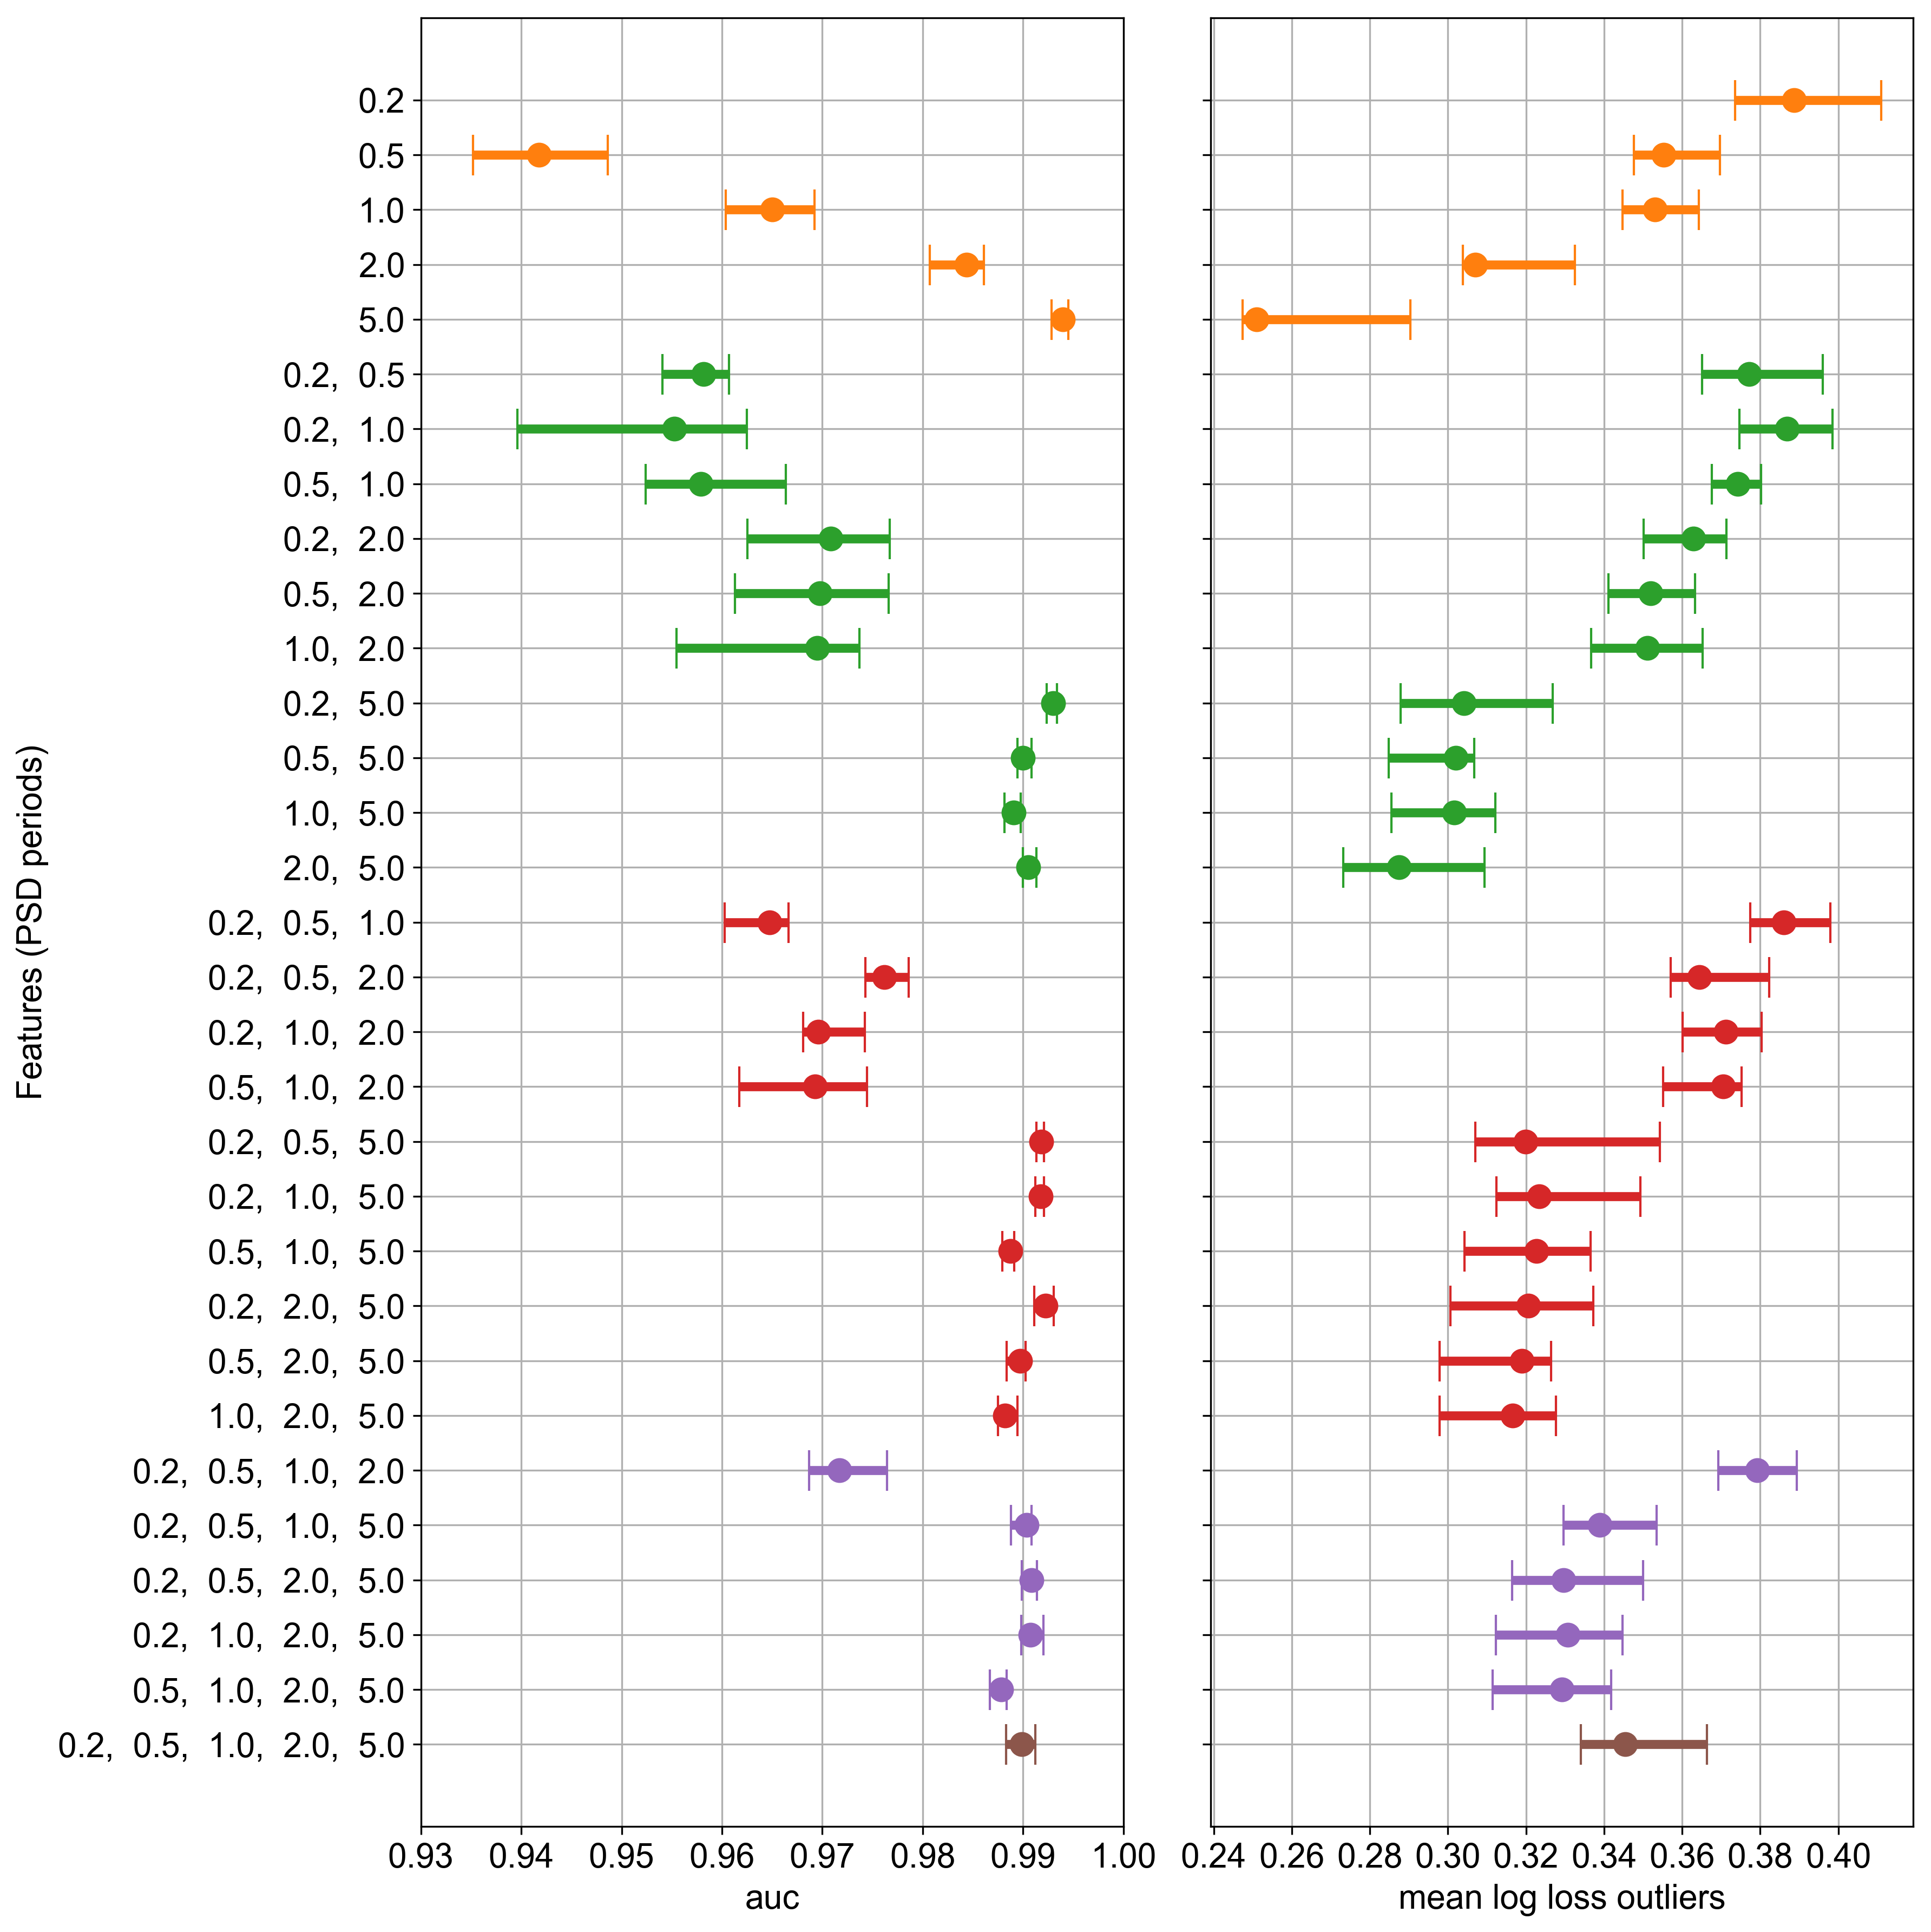

The plot shows that 
1) psd@5seconds is the best feature: when present, scores are lower (less loss=>better)
2) Adding features reduces the score variance but increases the score median, as expected
Note however that called D the mean log loss difference between two models.
the mean difference of scores is: 1 - 10 ** D


In [3]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

# tmp_fig_size = matplotlib.rcParams['figure.figsize']
# matplotlib.rcParams['figure.figsize']
# plt.rcParams.update({'font.size': 30})
# plt.rcParams.update({'figure.figsize': (22, 22)})


from itertools import cycle
basecolors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

colors_ = iter(cycle(basecolors))
colorsdict = defaultdict(lambda: next(colors_))

plots = ['auc', 'mean log loss outliers', 'best_thres_mean recall']
data = {l:defaultdict(list) for l in plots}
features = set()

# data is a dict of features -> [log_loss1, ..., log_lossN], [auc_1, ..., auc_N], [%rec_outl1, ..., %rec_outlN]
for _, df_ in eval_df.groupby('features'):
    for p in plots:
        data[p][_].extend(_ for _ in df_[p])
        features.add(_)    

def get_periods(label):
    '''returns the sorted periods from a feature label. E.g. from "psd@0.2sec,psd@5sec" to [0.2, 5]'''
    # label is something like 'psd@0.2sec,psd@5sec'. First grab the periods (0.2, 5):
    return sorted(float(_[:_.rfind('sec')][_.find('@')+1:]) for _ in label.split(','))


def get_color_from_feat_label(label):
    return basecolors[len(get_periods(label))]

# sort features:
features = sorted(features,
                  # sort by number of features first, and in case same number, by sum of periods then:
                  key=lambda f: 1000 * len(get_periods(f)) + sum(get_periods(f)),
                  reverse=True)

# do not show accuracy (which is actually mean recall):
# Three plots are too much  and confusing.
# We decide to show first auc, then mean log loss on outliers:
plots2show = plots[:2]

with plotparams({'figure.figsize': (12, 12), 'font.size': 15, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fix, axes = plt.subplots(1, len(plots2show))  #, gridspec_kw={'width_ratios': [1, 2, 2]})

    for ax, title in zip(axes, plots2show):
        plotdata = data[title]
        for i, label in enumerate(features):
            values = plotdata[label]
            avg = np.quantile(values, 0.5)
            xerr = [[avg-np.nanmin(values)], [np.nanmax(values)-avg]]
            ax.errorbar(avg, i, xerr=xerr, color=get_color_from_feat_label(label),
                         marker='o', capsize=9,
                         linewidth=4, elinewidth=4, markersize=10)
        # plt.title('Min, Median, Max of mean log loss on outliers\n(colors denote the number of features)')
        lbls = [",  ".join("%.1f" % __ for __ in get_periods(_)) for _ in features]
        ax.set_yticks(list(range(len(features))))
        if ax is axes[0]:
            ax.set_yticklabels(lbls)  # ["".join("2.2f" % _ for _ in get_periods(lbl)) for lbl in labels])
            ax.set_ylabel('Features (PSD periods)')
        else:
            ax.set_yticklabels(['' for _ in lbls])

        if title == plots[0]: # auc
            ax.set_xlim([0.93, 1])
            
        ax.set_xlabel(title)
        ax.grid()
#     plt.yticklabels(labels)

plt.tight_layout()
plt.show()


print('The plot shows that ')
print('1) psd@5seconds is the best feature: when present, scores are lower (less loss=>better)')
print('2) Adding features reduces the score variance but increases the score median, as expected')
print('Note however that called D the mean log loss difference between two models.')
print('the mean difference of scores is: 1 - 10 ** D')

In [4]:
# now show the best N models. Define the 
N = 20
cols2print = ['features', 'n_estimators', 'max_samples']
sortorder = [False, True, False]
with pd.option_context("display.max_colwidth", 80):
    for sorder, p in zip(sortorder, plots):
        print()
        print('Best %d models sorted by %s' % (N, p))
        print(eval_df[cols2print + [p]].sort_values(by=[p], ascending=sorder)[:N].to_string(index=False))
#     dfr_auc2 = dfr_auc.drop(['contamination', 'classifier', 'behaviour'], 1)
#     dfr_auc2['mean recall@bt'] = .5*(dfr_auc2.best_thres_tnr + dfr_auc2.best_thres_tpr)
#     # dfr_auc2 = dfr_auc2.drop(['best_thres_tnr', 'best_thres_tpr'], 1)
#     dfr_auc2.features = dfr_auc2.features.str.replace('psd@', '').str.replace('sec', '') #.str.replace('psd@', '')
#     dfr_auc2 = dfr_auc2.rename({'best_thres': 'bt', 'best_thres_tnr': 'fnr@bt', 'best_thres_tpr': 'tpr@bt'}, axis=1)
#     print('Best %d models sorted by auc')
#     print(eval_df.sort_values(by=['auc'], ascending=False)[:N].to_string(index=False))
#     print()
#     print('Best %d models sorted by recall@bt. Legend: bt=best (roc) threshold')
#     print(dfr_auc2.sort_values(by=['mean recall@bt'], ascending=False)[:N].to_string(index=False))
#     # now print best 10 by log loss:
#     dfr_ = dfr.sot_values(by=[''])



Best 20 models sorted by auc
features  n_estimators  max_samples       auc
                    psd@5sec           200         2048  0.994533
                    psd@5sec           100         2048  0.994291
                    psd@5sec           200          512  0.994114
                    psd@5sec           100          512  0.994020
                    psd@5sec            50         2048  0.993958
                    psd@5sec            50          512  0.993706
                    psd@5sec           200         8192  0.993473
         psd@0.2sec,psd@5sec           100         8192  0.993375
         psd@0.2sec,psd@5sec           200         8192  0.993294
         psd@0.2sec,psd@5sec            50          512  0.993278
                    psd@5sec           100         8192  0.993166
         psd@0.2sec,psd@5sec           200         2048  0.993067
psd@0.2sec,psd@2sec,psd@5sec            50         2048  0.993055
         psd@0.2sec,psd@5sec            50         8192  0.992993


In [64]:
import pandas as pd

print('Final decision: we take the best model in recognizing outliers (i.e., with minimum log loss on outliers)')
print('Among the best, we choose actually the first that has t=50 because is way more efficient')
print('We then take the best model with average los loss, and t=50')
print('Among the best, we choose actually the second best because it has t=50 and is way more efficient')

print('TODO: take also the best two models overall, to compare performances afterwards and check that we do not')
print('decrease too much')

# best average, best outlier, best inlier
# best average t=50, best outlier t=50, best inlier t=50
# best average t=50 , best outlier t=50, best inlier t=50

rootdir = maindir.replace('evalreports', '')


# adding the two best with two features, with contamination 5% an 10%
# fnames = {
#     # 'best_avg_t50': 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
#     'best_avg': 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200',
#     # 'best_out_same_t_psi': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
#     # 'best_inl_same_t_psi': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
#     # 'best_inl_t50': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
#     'best_outl_t50': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50',
#     'best_outl_t100': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100',
#     'best_outl': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
# }

# ACTUALLY, LOAD ALL MODELS with psd@5sec
fnames = {_.replace('IsolationForest?', '').replace('&behaviour=new&contamination=auto', '').replace('.model', ''):
          _.replace('.model', '') for _ in os.listdir(os.path.join(rootdir, 'models')) if 'features=psd@5sec&' in _}

# add the best avg:
fnames['features=psd@2sec,psd@5sec&max_samples=2048&n_estimators=200'] = 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200'
    
print()
print('Loading models and predictions')

clfs = {k: load(os.path.join(rootdir, 'models', v + '.model')) for k, v in fnames.items()}
pred_dfs = {k: pd.read_hdf(os.path.join(rootdir, 'predictions', v + '.hdf')) for k, v in fnames.items()}

for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))
# print('loading source trainset')
# dataframe = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)

Final decision: we take the best model in recognizing outliers (i.e., with minimum log loss on outliers)
Among the best, we choose actually the first that has t=50 because is way more efficient
We then take the best model with average los loss, and t=50
Among the best, we choose actually the second best because it has t=50 and is way more efficient
TODO: take also the best two models overall, to compare performances afterwards and check that we do not
decrease too much

Loading models and predictions
features=psd@5sec&max_samples=2048&n_estimators=100: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
features=psd@5sec&max_samples=2048&n_estimators=200: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=2048, n_estimators=200,
                n_jobs=None

SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS
Note that the max_samples parameter dictates the distribution shape


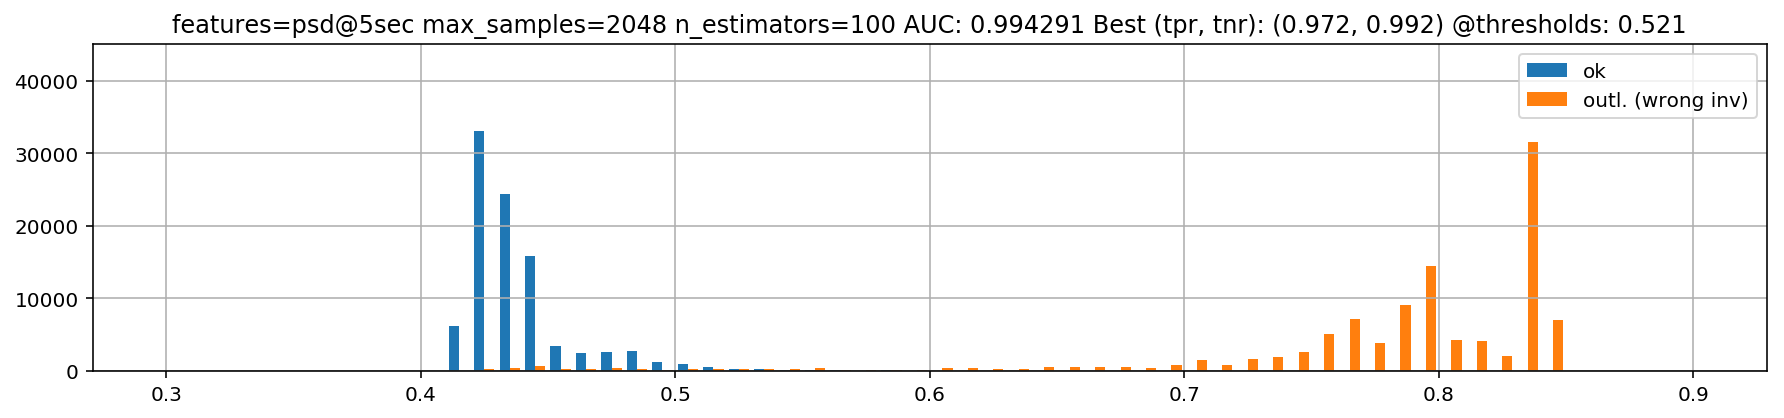

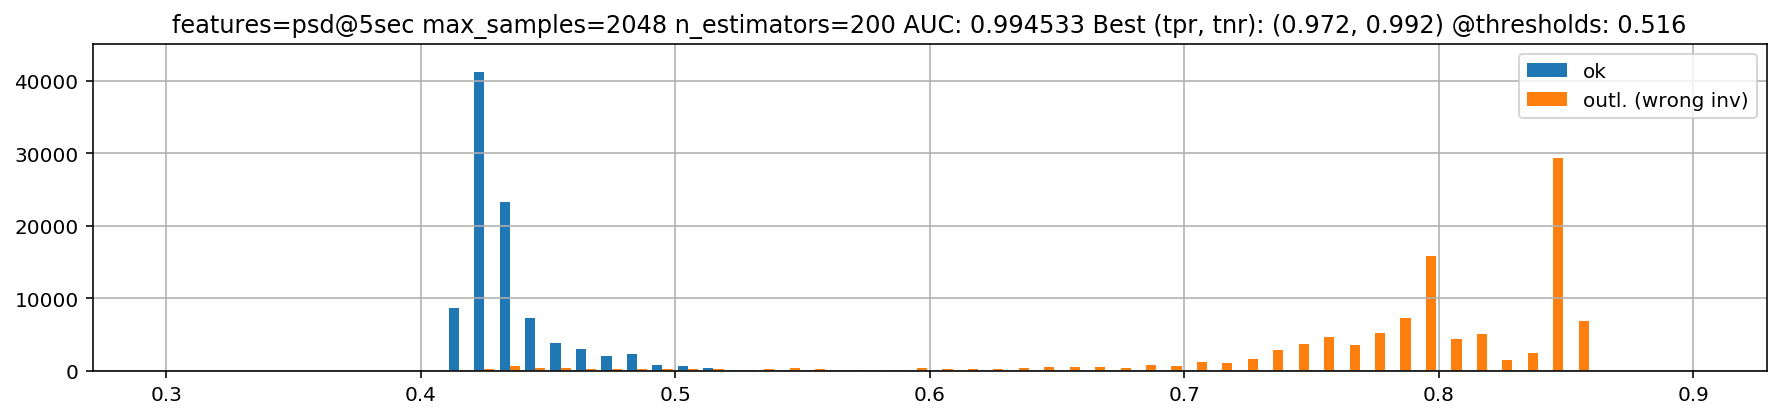

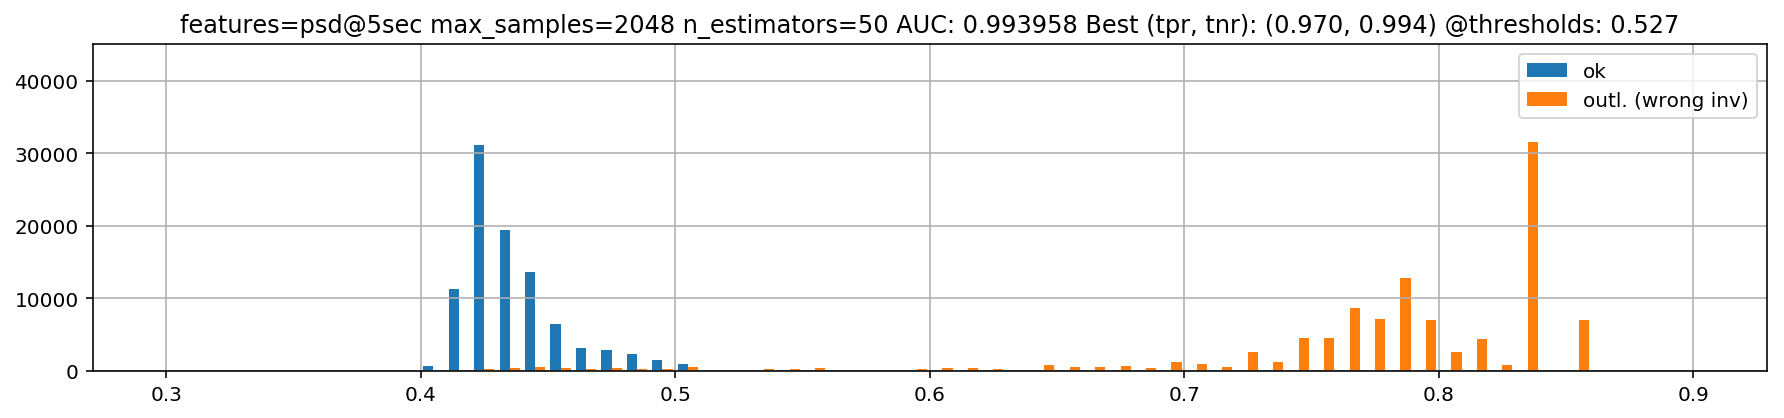

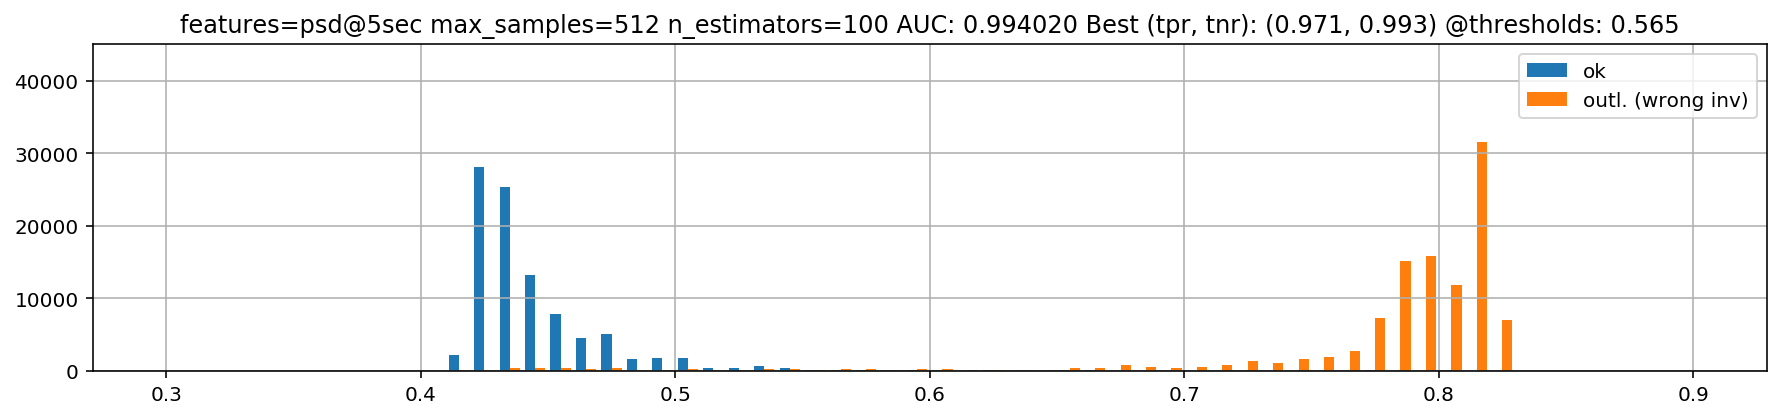

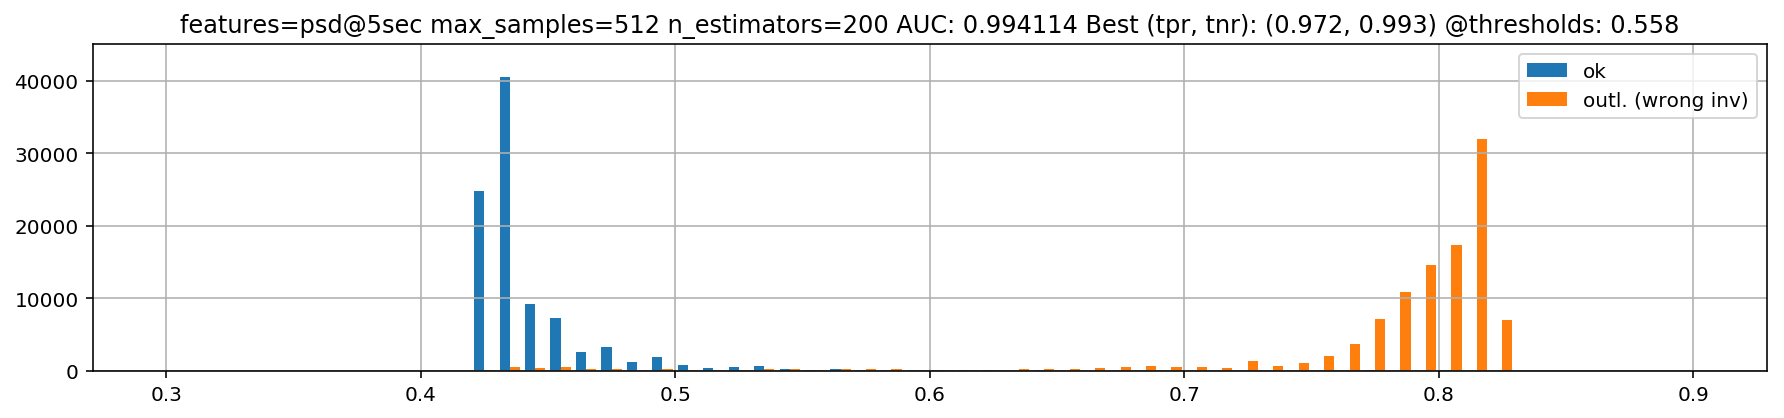

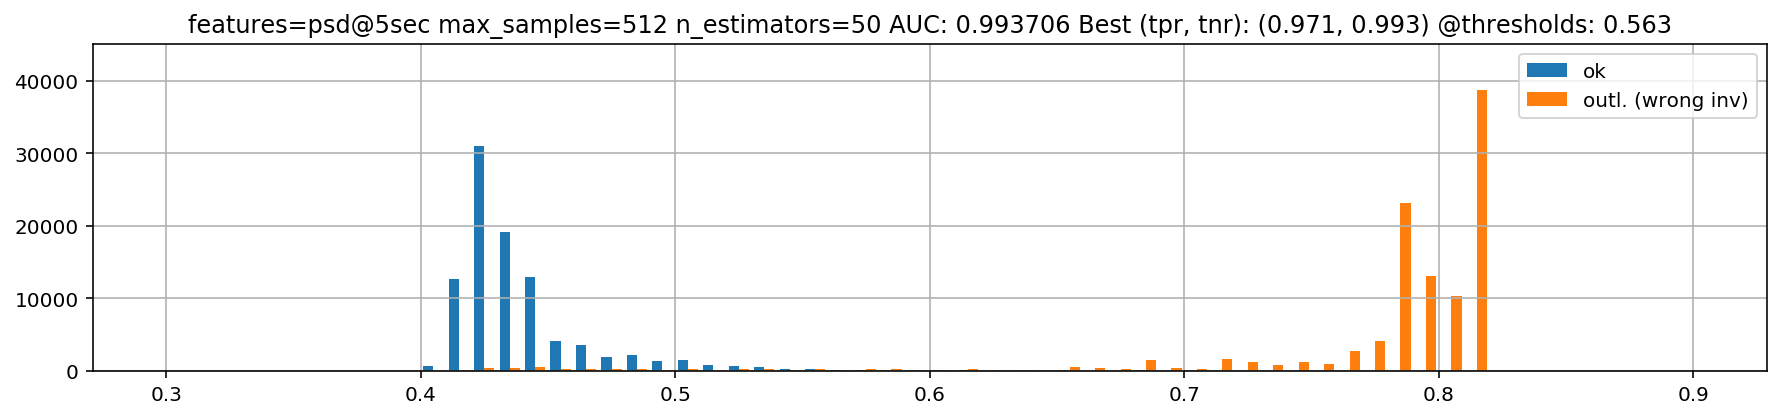

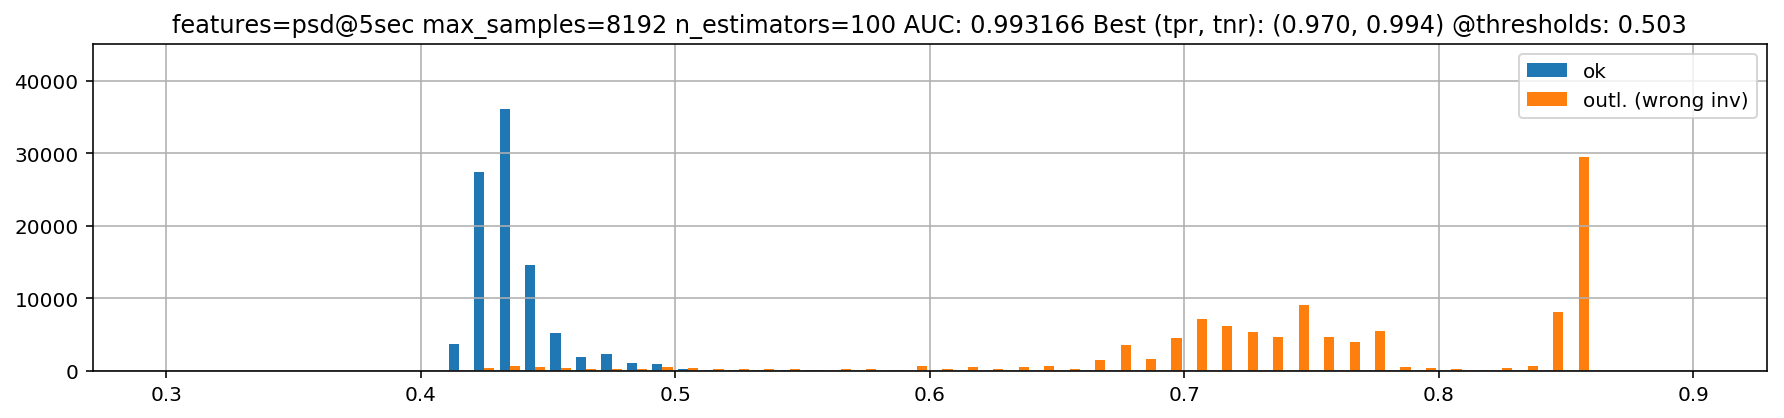

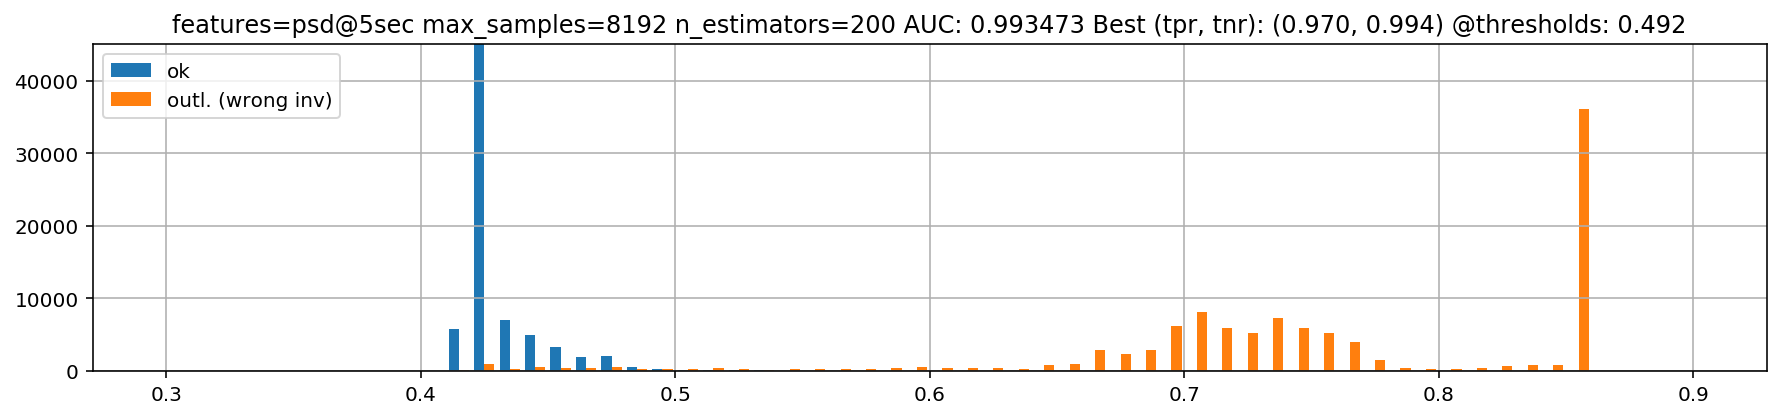

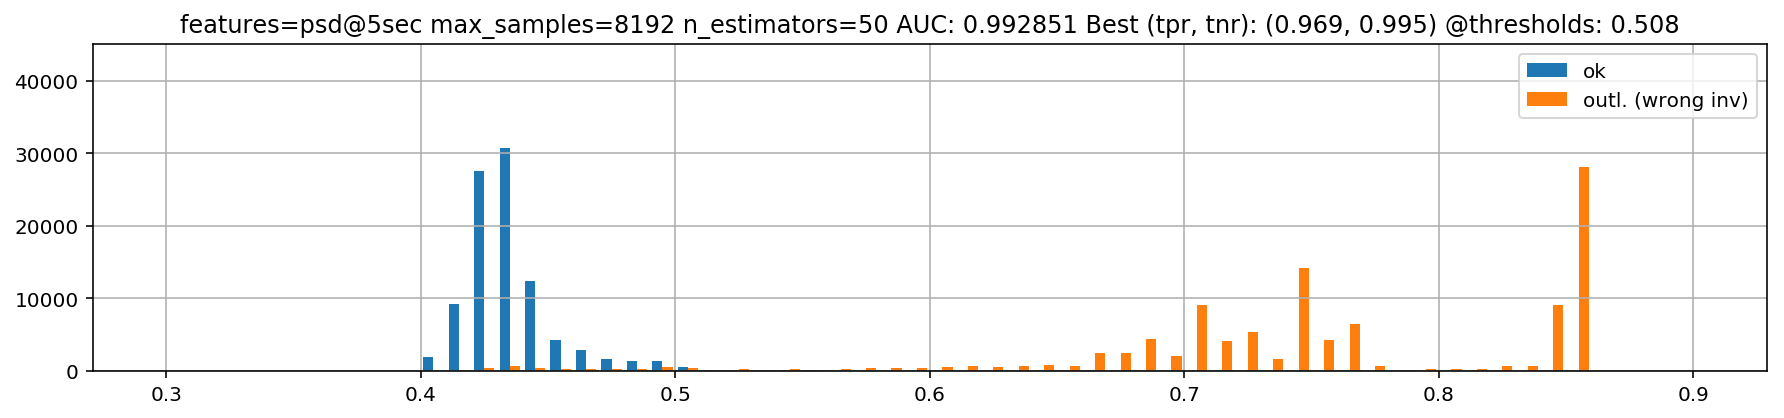

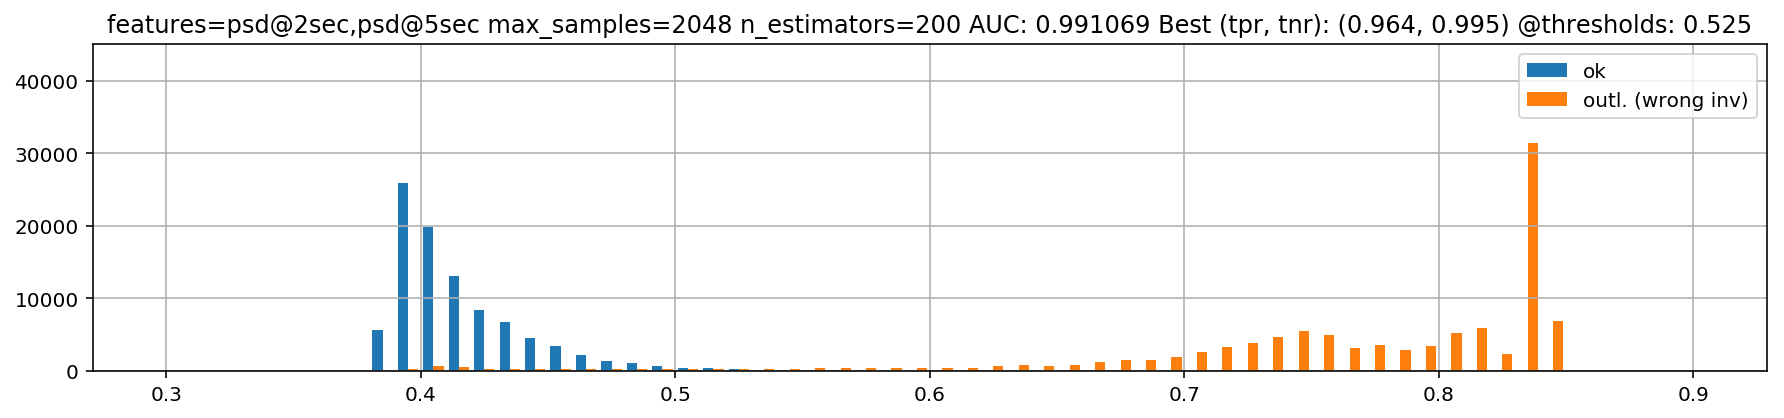

In [6]:
from sod.core.dataset import dataset_info, allset_test


class_inlier = allset_test.classnames[0]
class_outlier = allset_test.classnames[1]
class_me_unknown = allset_test.classnames[2]

sel_inlier = allset_test.class_selector[class_inlier]
sel_outlier = allset_test.class_selector[class_outlier]
sel_me_unknown = allset_test.class_selector[class_me_unknown]


import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

# create the data to plot:
data = []
for name, pred_df in pred_dfs.items():
    params = {p.split('=')[0]: p.split('=')[1] for p in name.split('&')}
    pred_df_auc = dfr_auc[
        (dfr_auc.n_estimators==float(params['n_estimators'])) &
        (dfr_auc.max_samples==float(params['max_samples'])) &
        (dfr_auc.features==params['features'])
    ]
    assert len(pred_df_auc) == 1
    auc_ = pred_df_auc['auc'].values[0]
    best_thres = pred_df_auc['best_thres'].values[0]
    best_thres_tnr = pred_df_auc['best_thres_tnr'].values[0]
    best_thres_tpr = pred_df_auc['best_thres_tpr'].values[0]
    data.append({
        'name': name,
        'plotdata': [
            pred_df[sel_inlier(pred_df)].predicted_anomaly_score,
            pred_df[sel_outlier(pred_df)].predicted_anomaly_score,
            # pred_df[sel_me_unknown(pred_df)].predicted_anomaly_score
        ],
        'auc': auc_,
        '%rec': 'Best (tpr, tnr): (%.3f, %.3f) @thresholds: %.3f' % (best_thres_tpr, best_thres_tnr, best_thres) 
    })

# sort by auc
# data = sorted(data, key = lambda _: _['%rec'], reverse=True)
print('SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS')
print('Note that the max_samples parameter dictates the distribution shape')

%matplotlib inline
import numpy as np
bins = np.arange(0.3, .9, 0.01)
with plotparams({'figure.figsize': (15, 3)}):
    for d in data:
        plt.hist(d['plotdata'], bins=bins, log=False, histtype='bar', stacked=False, label=[class_inlier, class_outlier, class_me_unknown])
        plt.grid()
        plt.ylim([1, 45000]) #  10**5])
        plt.legend()
        plt.title(d['name'].replace('&', ' ') + ' AUC: %f' % d['auc'] + ' ' + d['%rec'])
        plt.show()

SCORES DISTRIBUTIONS ON SEGMENTS: ME UNKNOWN
features=psd@5sec&max_samples=2048&n_estimators=100


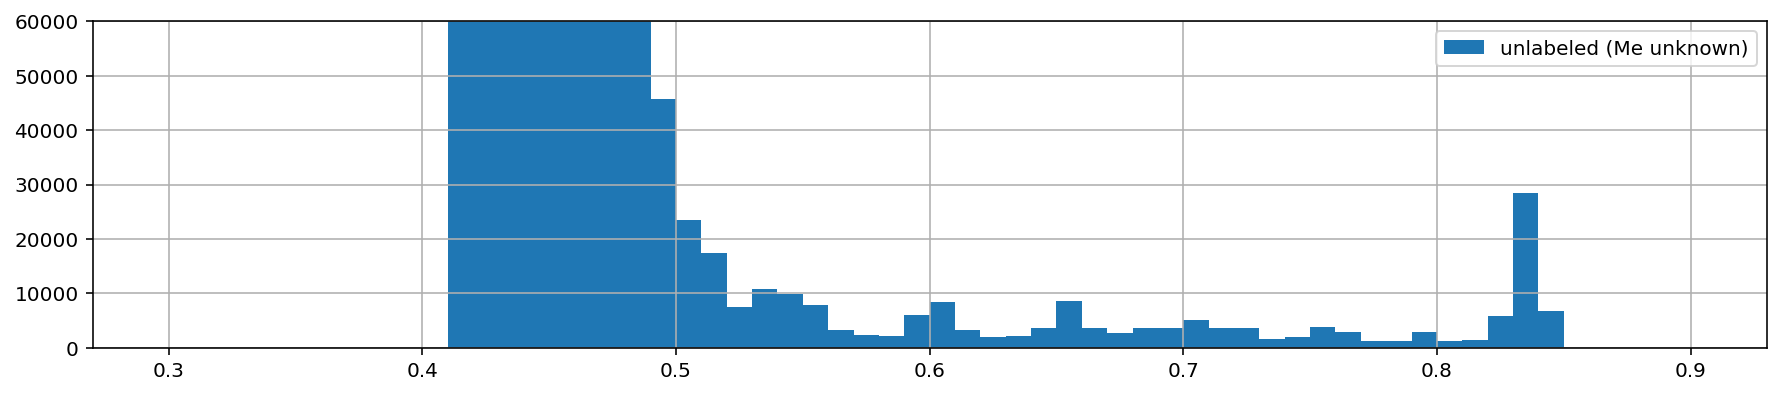

features=psd@5sec&max_samples=2048&n_estimators=200


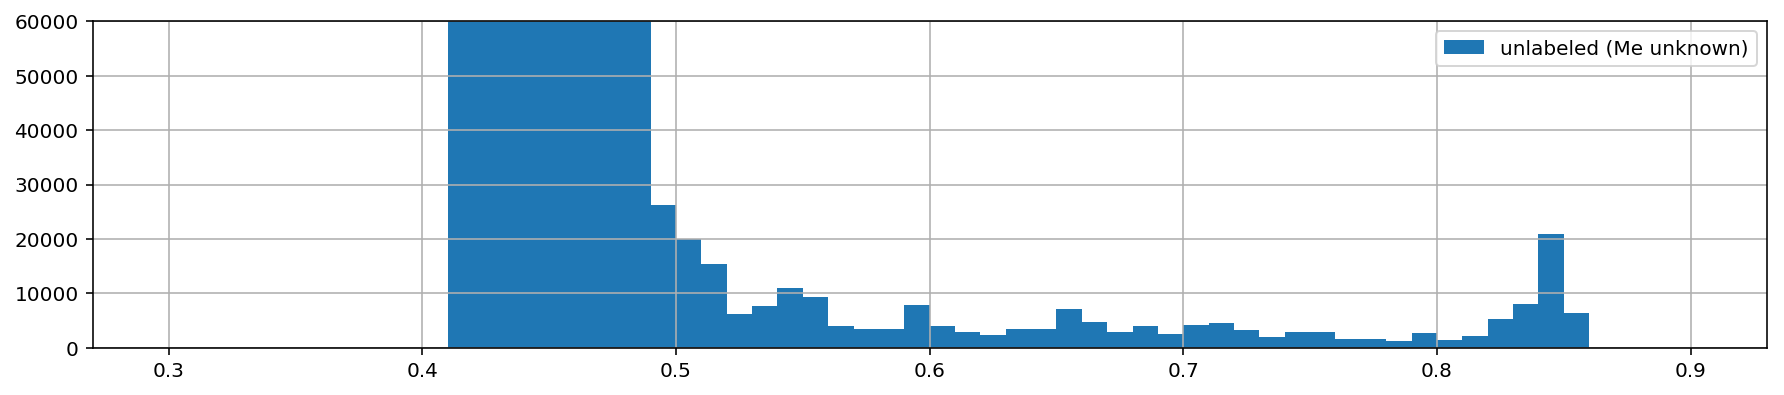

features=psd@5sec&max_samples=2048&n_estimators=50


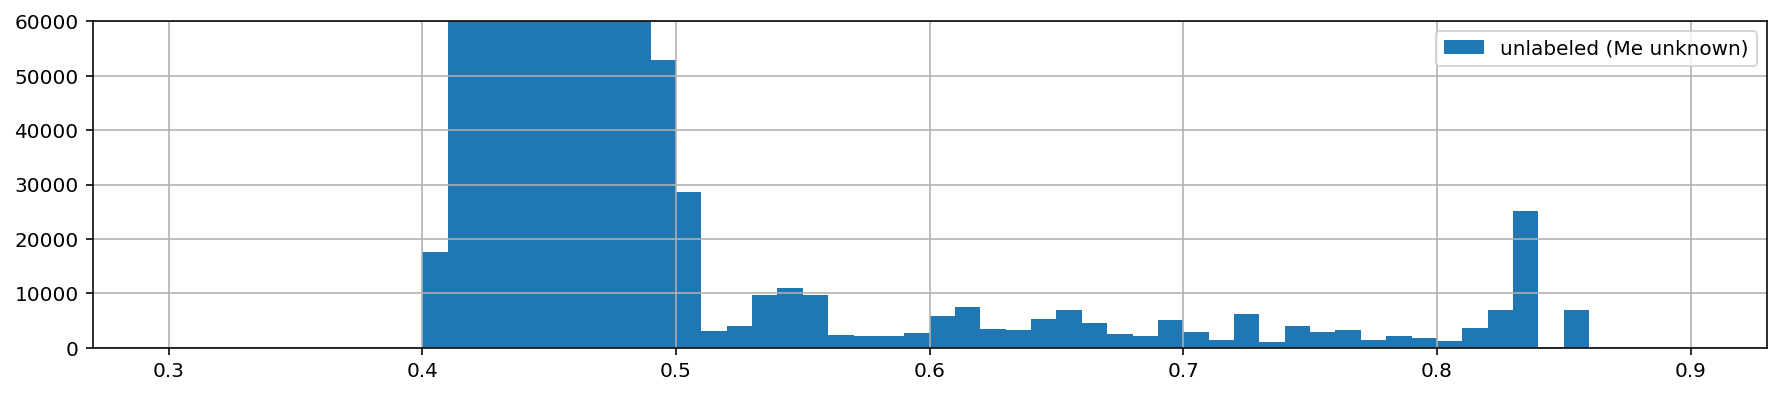

features=psd@5sec&max_samples=512&n_estimators=100


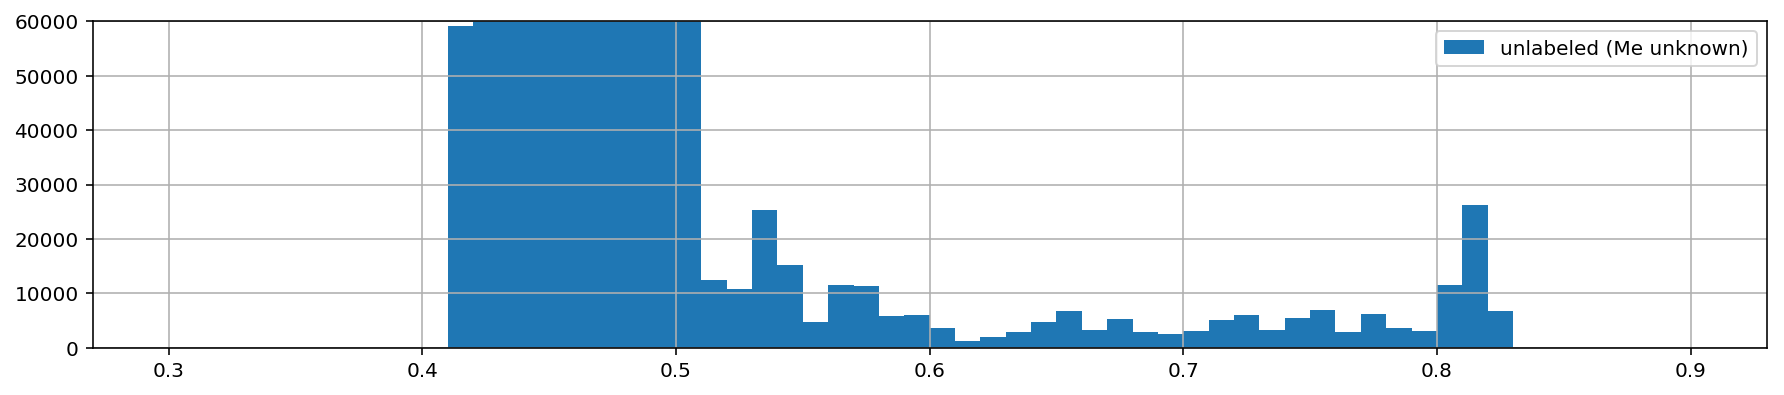

features=psd@5sec&max_samples=512&n_estimators=200


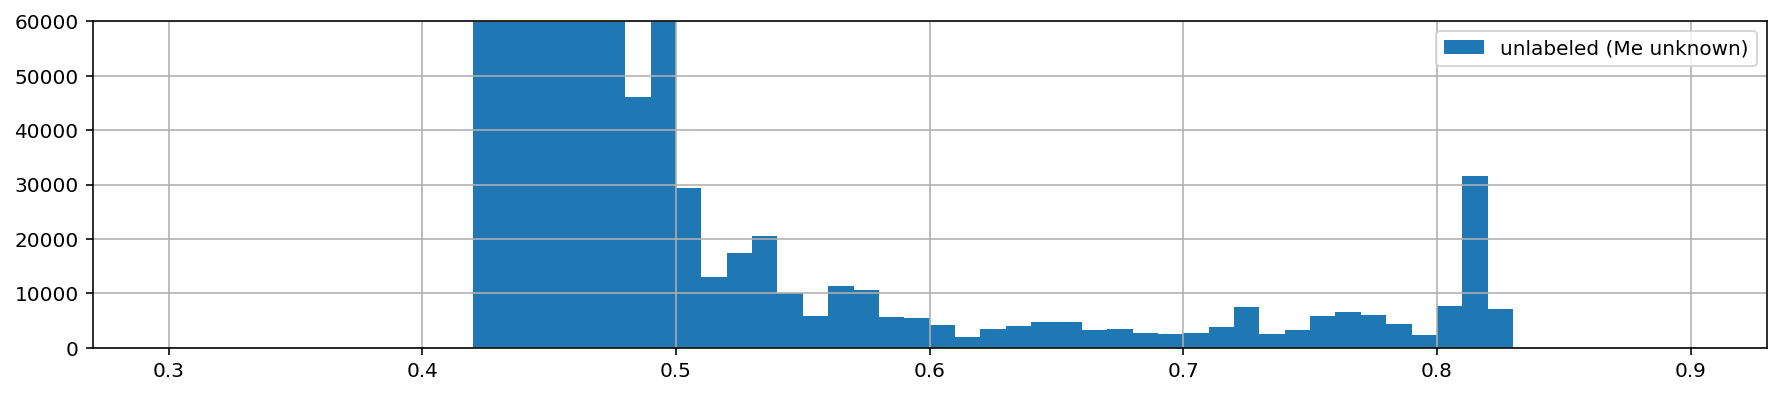

features=psd@5sec&max_samples=512&n_estimators=50


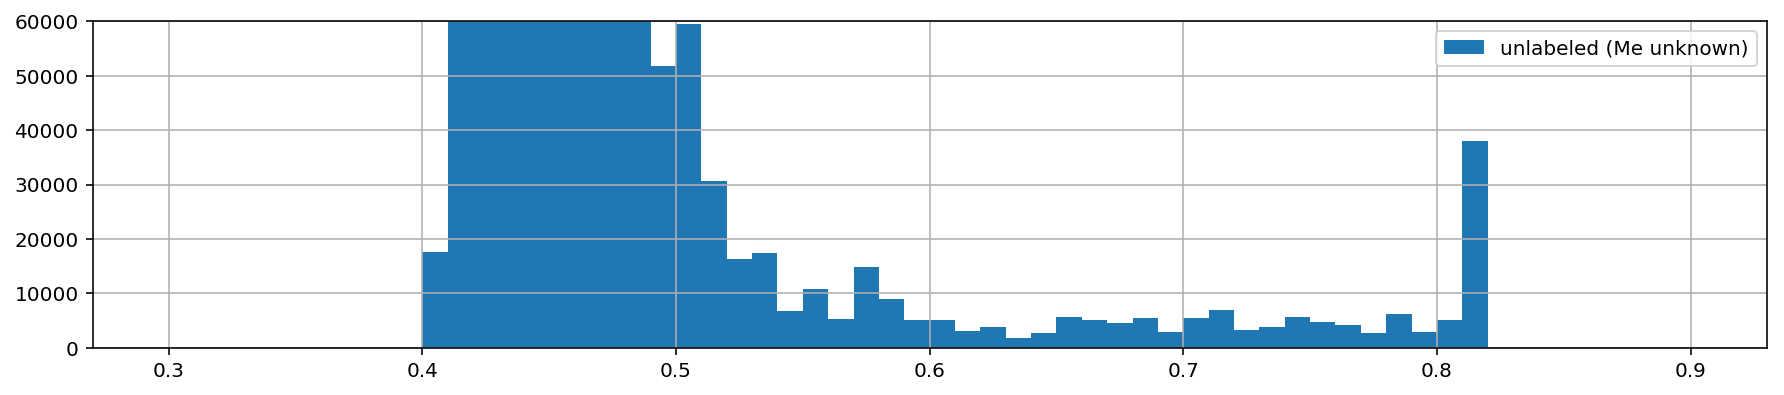

features=psd@5sec&max_samples=8192&n_estimators=100


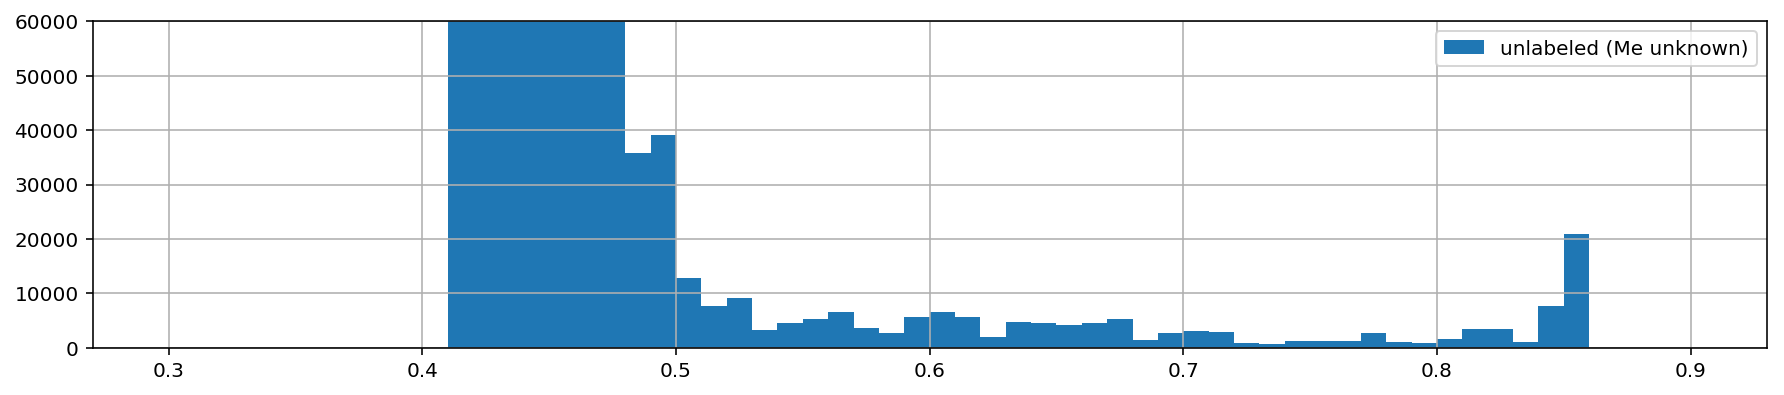

features=psd@5sec&max_samples=8192&n_estimators=200


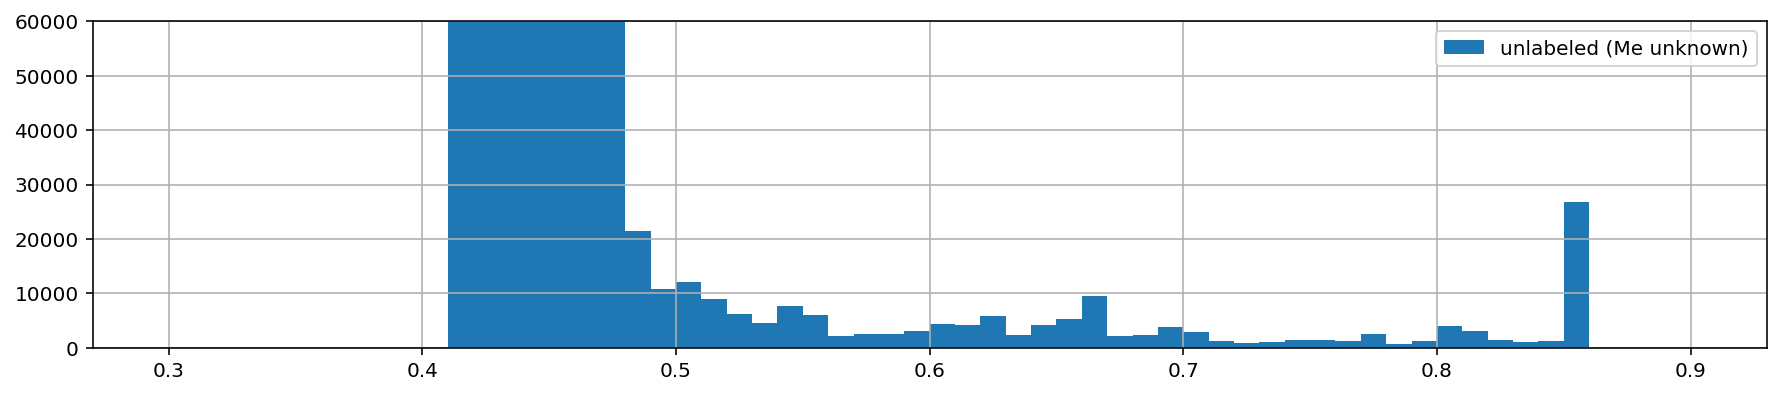

features=psd@5sec&max_samples=8192&n_estimators=50


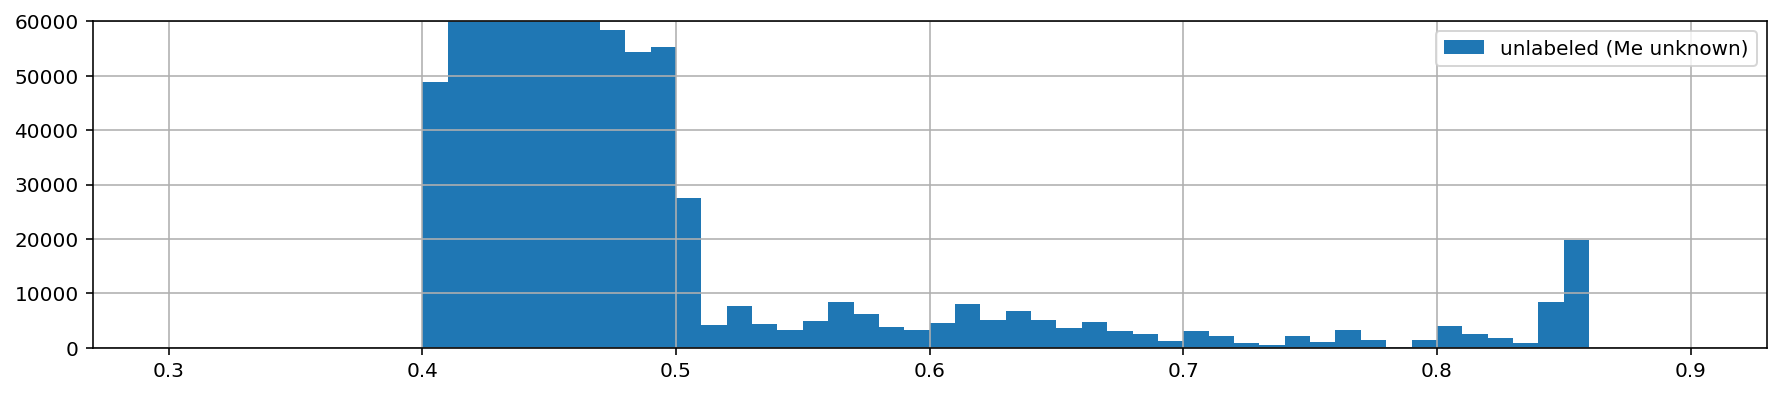

features=psd@2sec,psd@5sec&max_samples=2048&n_estimators=200


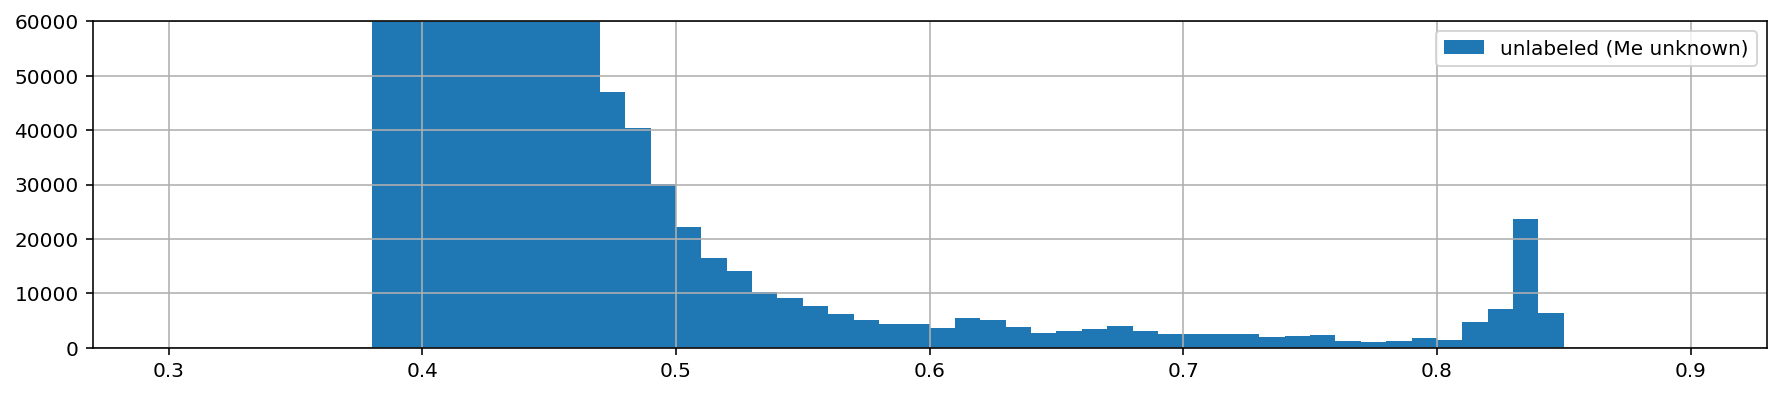

In [7]:
# Scores distributions of unknown

from sod.core.dataset import dataset_info, allset_test


class_inlier = allset_test.classnames[0]
class_outlier = allset_test.classnames[1]
class_me_unknown = allset_test.classnames[2]

sel_inlier = allset_test.class_selector[class_inlier]
sel_outlier = allset_test.class_selector[class_outlier]
sel_me_unknown = allset_test.class_selector[class_me_unknown]


import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

print('SCORES DISTRIBUTIONS ON SEGMENTS: ME UNKNOWN')

%matplotlib inline
import numpy as np
bins = np.arange(0.3, .9, 0.01)
with plotparams({'figure.figsize': (15, 3)}):
    for name, pred_df in pred_dfs.items():
        print(name)
        data = [
            # pred_df[sel_inlier(pred_df)].predicted_anomaly_score + offsets[name],
            # pred_df[sel_outlier(pred_df)].predicted_anomaly_score + offsets[name],
            pred_df[sel_me_unknown(pred_df)].predicted_anomaly_score
        ]
        
        plt.hist(data, bins=bins, log=False, histtype='bar', stacked=False, label=[class_me_unknown])
        plt.grid()
        plt.ylim([0, 60000]) #  10**5])
        plt.legend()
        plt.show()

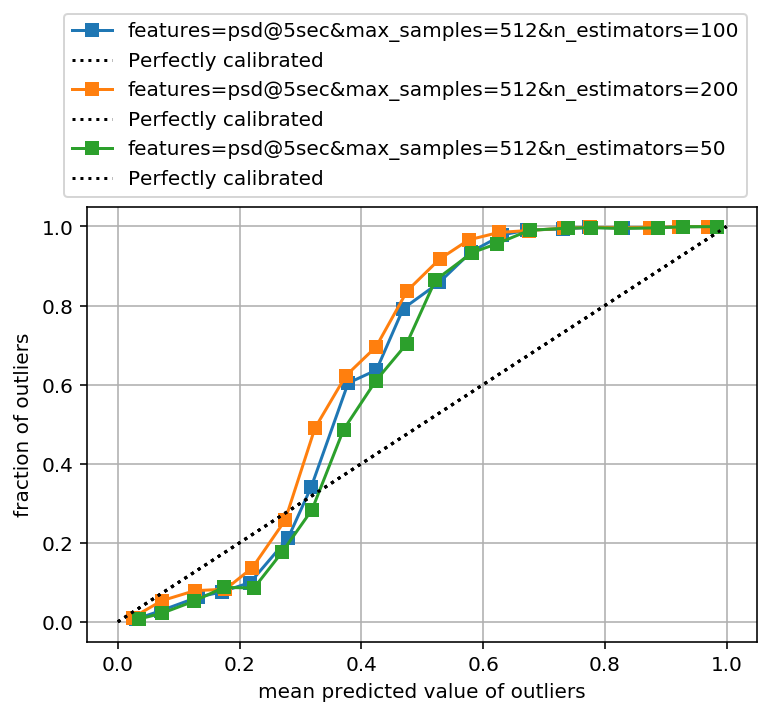

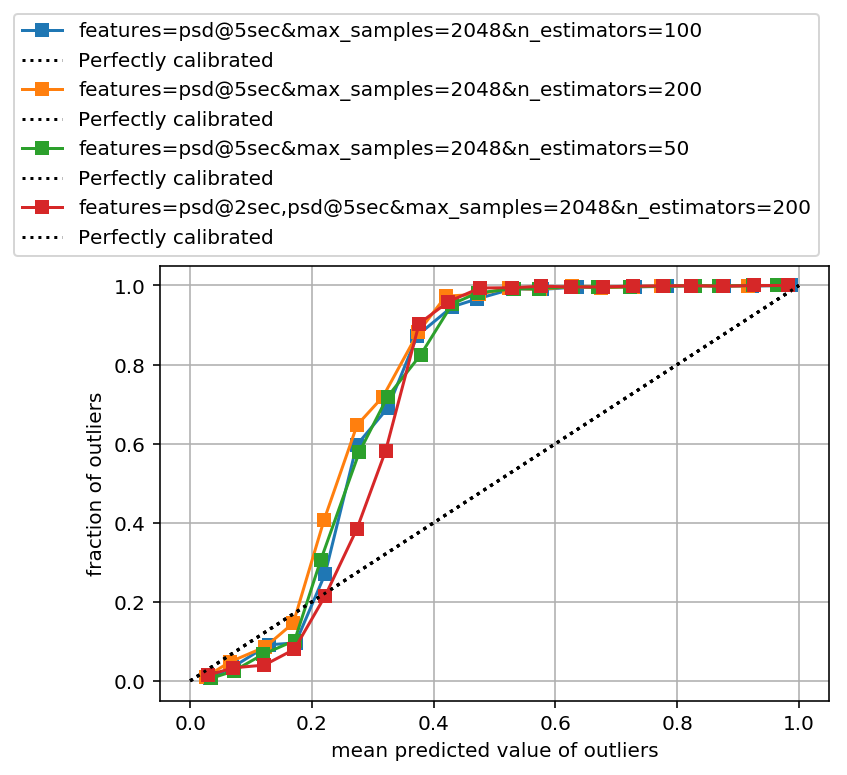

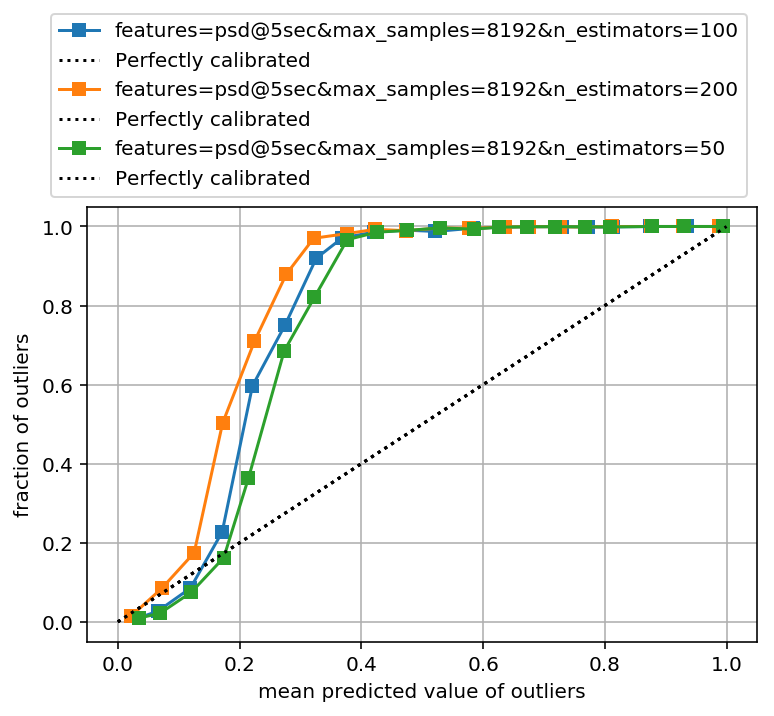

In [8]:
# let's plot calibration curves:
# (https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html)
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

groups = ['max_samples=512', 'max_samples=2048', 'max_samples=8192']

for group in groups:
    for name, pred_df in pred_dfs.items():
        if group not in name:
            continue
        _pred_df = pred_df[sel_inlier(pred_df) | sel_outlier(pred_df)] 
        mn, mx = _pred_df.predicted_anomaly_score.min(), _pred_df.predicted_anomaly_score.max()
        y_true = _pred_df.outlier
        scores = _pred_df.predicted_anomaly_score
        scores = (scores-mn) /(mx - mn)
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_true, scores, n_bins=20, normalize=False)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label=name)
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    plt.legend(loc='lower right', bbox_to_anchor=(1,1))
    plt.xlabel('mean predicted value of outliers')
    plt.ylabel('fraction of outliers')
    plt.grid()
    plt.show()
    

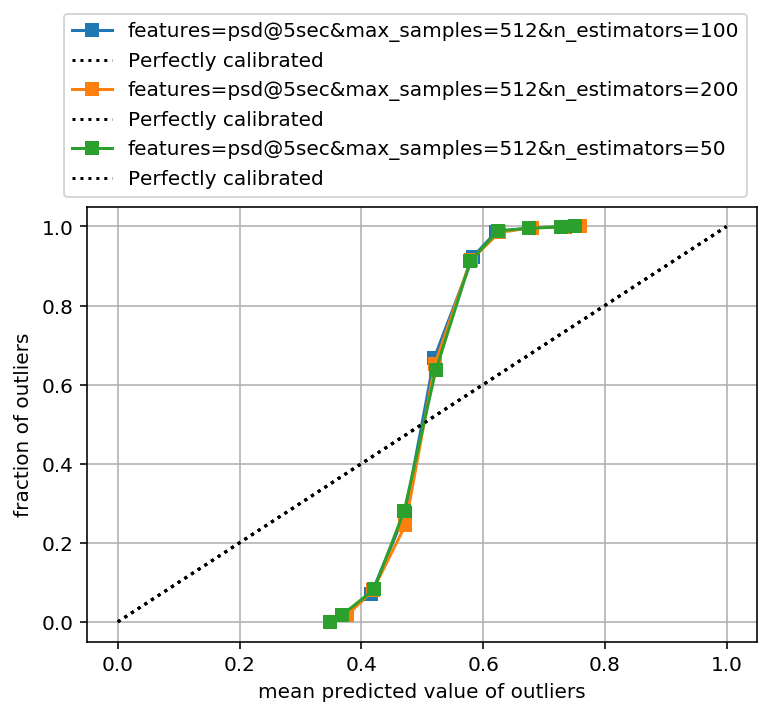

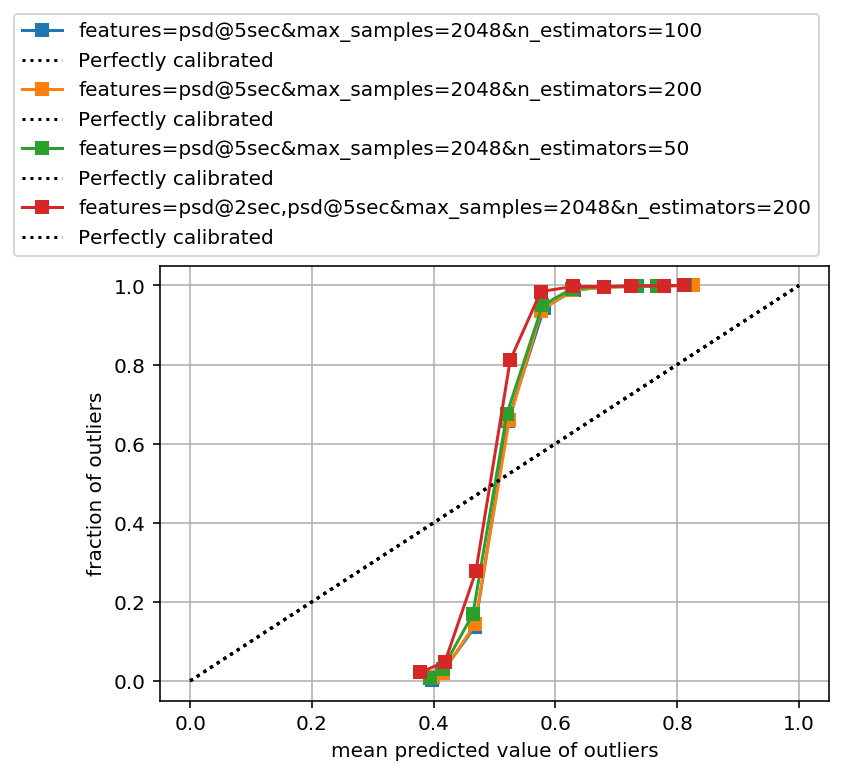

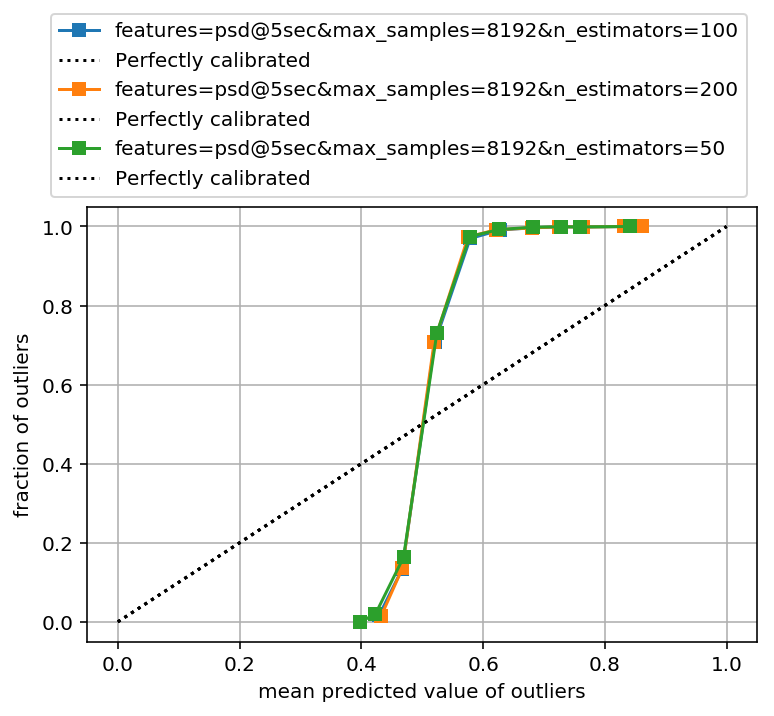

In [9]:
# same plot as above, but with "custom" offset
# let's plot calibration curves:
# (https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html)
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_curve

def normalize(scores, best_th):
    scores -= (best_th-0.5)
    return scores

groups = ['max_samples=512', 'max_samples=2048', 'max_samples=8192']

for group in groups:
    for name, pred_df in pred_dfs.items():
        if group not in name:
            continue
        _pred_df = pred_df[sel_inlier(pred_df) | sel_outlier(pred_df)] 
        # mn, mx = _pred_df.predicted_anomaly_score.min(), _pred_df.predicted_anomaly_score.max()
        y_true = _pred_df.outlier
        scores = _pred_df.predicted_anomaly_score

        # getting the threshold:
        fpr, tpr, thresholds = roc_curve(y_true, scores)
        idx = np.argmax((1-fpr[1:]) * tpr[1:])
        best_th = thresholds[1:][idx]
        # print(offset)
        scores = normalize(scores, best_th)

        # scores = (scores-mn) /(mx - mn)
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_true, scores, n_bins=20, normalize=False)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label=name)
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    plt.legend(loc='lower right', bbox_to_anchor=(1,1))
    plt.xlabel('mean predicted value of outliers')
    plt.ylabel('fraction of outliers')
    plt.grid()
    plt.show()
    



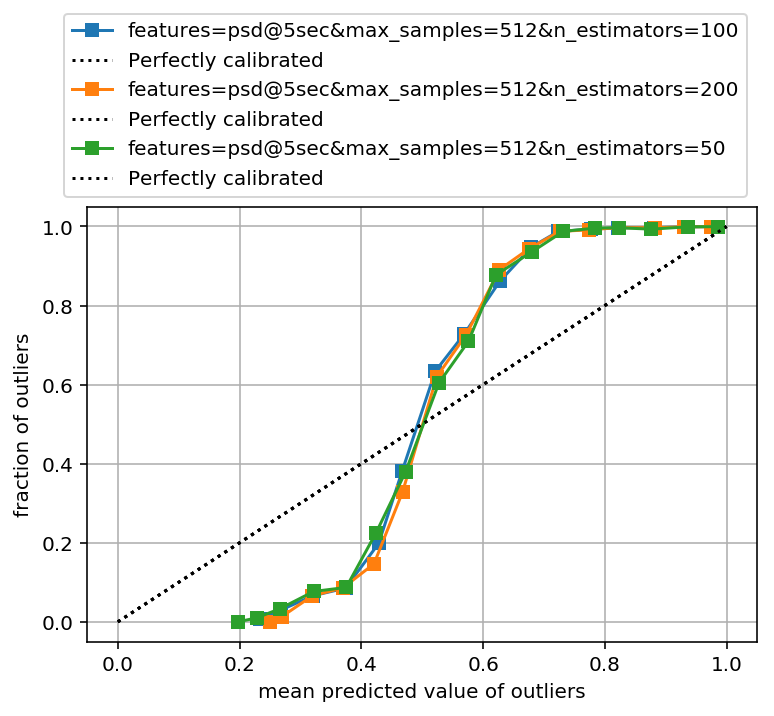

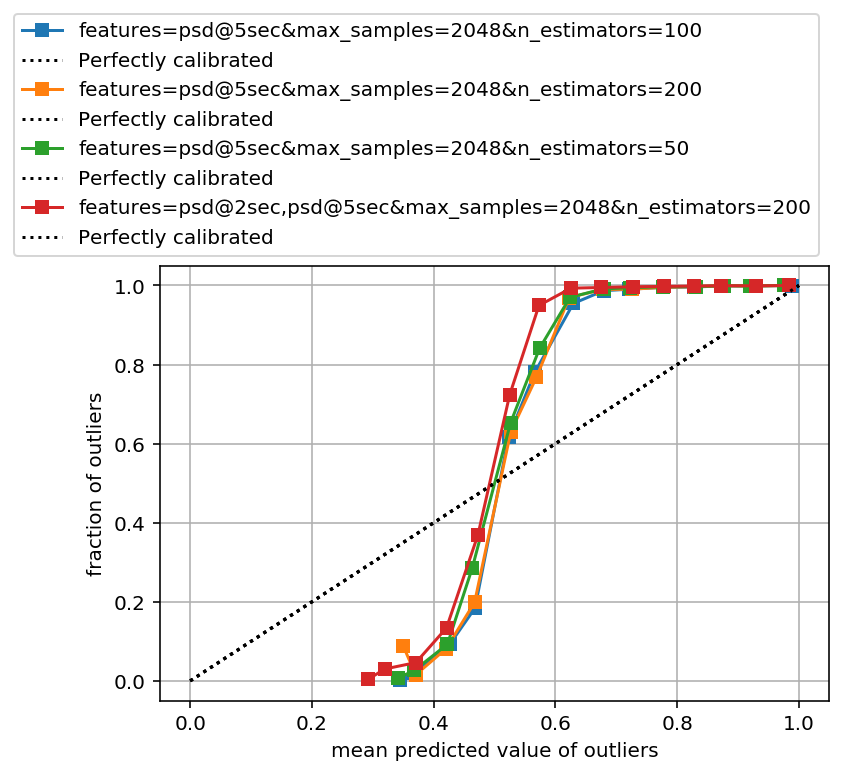

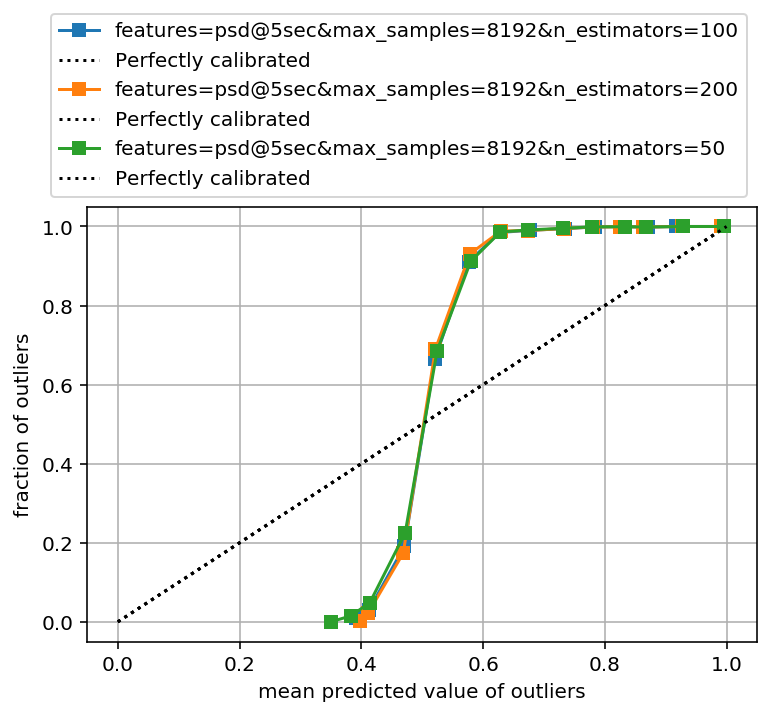

In [10]:
# same plot as above, but with "custom" offset and calibration (normalization) 
# let's plot calibration curves:
# (https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html)
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_curve

def normalize(scores, best_th):
    scores -= (best_th-0.5)
    # map 0.5 to 0.5, max to 1
    mx = np.max(scores)
    scores = 0.5 * ((scores - 0.5) / (mx-0.5)) + 0.5
    return scores
    

groups = ['max_samples=512', 'max_samples=2048', 'max_samples=8192']

for group in groups:
    for name, pred_df in pred_dfs.items():
        if group not in name:
            continue
        _pred_df = pred_df[sel_inlier(pred_df) | sel_outlier(pred_df)] 
        # mn, mx = _pred_df.predicted_anomaly_score.min(), _pred_df.predicted_anomaly_score.max()
        y_true = _pred_df.outlier
        scores = _pred_df.predicted_anomaly_score

        # getting the threshold:
        fpr, tpr, thresholds = roc_curve(y_true, scores)
        idx = np.argmax((1-fpr[1:]) * tpr[1:])
        best_th = thresholds[1:][idx]
        # print(offset)
        scores = normalize(scores, best_th)

        # scores = (scores-mn) /(mx - mn)
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_true, scores, n_bins=20, normalize=False)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label=name)
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    plt.legend(loc='lower right', bbox_to_anchor=(1,1))
    plt.xlabel('mean predicted value of outliers')
    plt.ylabel('fraction of outliers')
    plt.grid()
    plt.show()
    



Calculating performances, please wait


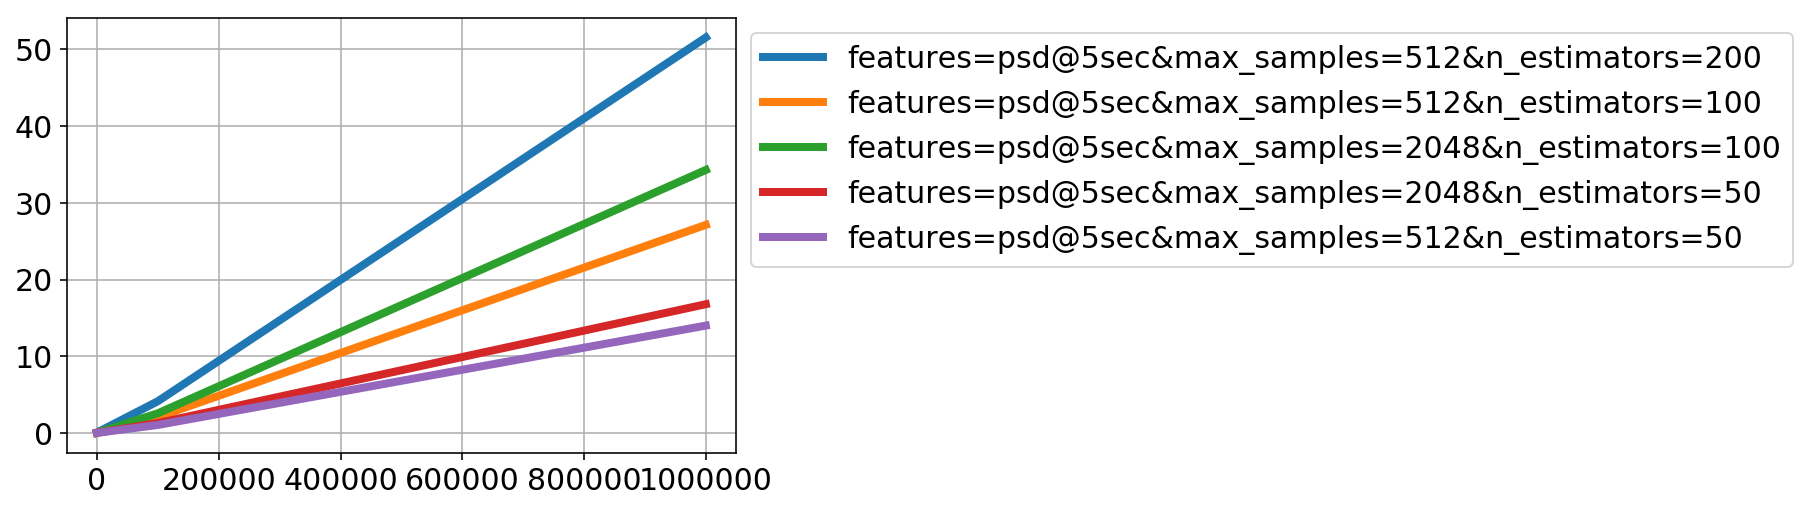

In [42]:
import numpy as np
from collections import defaultdict
import time
import itertools


# now some performances. We chosse:
names = [
    'features=psd@5sec&max_samples=512&n_estimators=200',
    'features=psd@5sec&max_samples=512&n_estimators=100',
    'features=psd@5sec&max_samples=2048&n_estimators=100',
    'features=psd@5sec&max_samples=2048&n_estimators=50',
    'features=psd@5sec&max_samples=512&n_estimators=50',
]

print('Calculating performances, please wait')

min_ = -180
max_ = -20

data = defaultdict(list)
numinstances = [100, 1000, 10000, 100000, 1e6]
for numinstance in numinstances:
    test = np.random.normal(-120, 30, (int(numinstance),1)) 
    for n in names:
        _ = clfs[n]
        t = time.time()
        .3 *(_.score_samples(test) - 0.5)-3  # emulate the model calculation + offset and normalization
        data[n].append(time.time() - t)


with plotparams({'font.size': 15}):
    for name, vals in data.items():
        plt.plot(numinstances, vals, label=name, linewidth=4)
        # plt.plot(y=list(data.values()), x=list(itertools.repeat(numinstances, len(data))), label=list(data.keys()))
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.show()

In [82]:
print('loading source testset')
allset_test = sod_core_dataset.open_dataset('allset_test.hdf', normalize=False, verbose=False)
print('Columns')
print(allset_test.columns.tolist())

# pd.read_hdf('/Users/riccardo/work/gfz/projects/sources/python/sod/sod/evaluations/results/eval.allset_train_test.iforest.yaml/predictions/IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50.hdf').columns

('allset_test.id', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier')


In [100]:
# moving to station / channel level
import numpy as np

# damn, we need to launch again predictions because the pred_dfs do not have dataset_id. So:
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)
test_df = allset_test[sel_inlier(allset_test) | sel_outlier(allset_test)]

problems = set()

print('Confusion matrices on a channel level (ignoring orientation code)'.split('='))
for name, clf in clfs.items():
    # create predictions
    features = ''
    for _ in name.split('&'):
        k, v = _.split('=')
        if k == 'features':
            features = v.split(',')
            break
    print('Predicting (features: %s)' % str(features))
    
    _prd_df = sod_core_eval.predict(clf, test_df, *features)
    # merge columns
    # _prd_df = pred_df.merge(allset_test['allset_test.id', 'dataset_id'], how='left', on=['allset_test.id'])
    # print(pred_df.columns)
    # _prd_df = pred_df[sel_inlier(pred_df) | sel_outlier(pred_df)].copy()
    _prd_df['cha_id'] = _prd_df.channel_code.str[:2]
    # now calculate the best offset (again)
    fpr, tpr, th = roc_curve(_prd_df.outlier, _prd_df.predicted_anomaly_score)
    argmax = np.argmax((1-fpr[1:])*tpr[1:])
    best_th = th[1:][argmax]
    scores = np.copy(_prd_df.predicted_anomaly_score.values)
    
    # offset: ====================
    scores += 0.5 - best_th
    # ============================
    
    # adjust: ====================
    _max = np.nanmax(scores)
    scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
    # ============================
    
    _prd_df['adjusted_scores'] = scores
    groups = \
        ['dataset_id', 'subclass', 'window_type', 'cha_id', 'location_code', 'station_id']
    groupz = _prd_df.groupby(groups)
    cm = pd.DataFrame(np.zeros(shape=(2,4), dtype=float), index=['inliers', 'outliers'],
                      columns=['CA inliers', 'CA outliers', 'MS inliers', 'MS outliers'])
    for ids, df_ in groupz:
        isoutlier = df_.outlier.sum()
        if not (isoutlier == len(df_) or isoutlier == 0):
            problems.add(ids)
            continue
        median = df_.adjusted_scores.median()
        if isoutlier and median > 0.5:
            cm.at['outliers', 'CA outliers'] += 1
            cm.at['outliers', 'MS outliers'] += median
        if not isoutlier and median >0.5:
            cm.at['inliers', 'CA outliers'] += 1
            cm.at['inliers', 'MS outliers'] += median
        if isoutlier and median <=0.5:
            cm.at['outliers', 'CA inliers'] += 1
            cm.at['outliers', 'MS inliers'] += median
        if not isoutlier and median <=0.5:
            cm.at['inliers', 'CA inliers'] += 1
            cm.at['inliers', 'MS inliers'] += median
    cm.at['outliers', 'MS outliers'] /= cm.at['outliers', 'CA outliers']
    cm.at['inliers', 'MS outliers'] /= cm.at['inliers', 'CA outliers']
    cm.at['outliers', 'MS inliers'] /= cm.at['outliers', 'CA inliers']
    cm.at['inliers', 'MS inliers'] /= cm.at['inliers', 'CA inliers']
    print('')
    print('')
    print(name + ' (best th: %f)' % best_th)
    print('Confusion matrix with instances grouped by: %s' % groups)
    print('CA: classified as, MS: mean score')
    print(cm.to_string(index=True))

if problems:
    print()
    print("These ('station_id', 'window_type', 'subclass', 'location_code', 'cha_id') ")
    print("were not used because they contained both ionliers and outliers:")
    print(problems)

['features', 'psd@5sec']
Predicting (features: ['psd@5sec'])


features=psd@5sec&max_samples=2048&n_estimators=100 (best th: 0.520936)
Confusion matrix with instances grouped by: ['dataset_id', 'subclass', 'window_type', 'cha_id', 'location_code', 'station_id']
CA: classified as, MS: mean score
          CA inliers  CA outliers  MS inliers  MS outliers
inliers        897.0         26.0    0.372536     0.720954
outliers         1.0         74.0    0.416173     0.936067
Predicting (features: ['psd@5sec'])


features=psd@5sec&max_samples=2048&n_estimators=200 (best th: 0.516447)
Confusion matrix with instances grouped by: ['dataset_id', 'subclass', 'window_type', 'cha_id', 'location_code', 'station_id']
CA: classified as, MS: mean score
          CA inliers  CA outliers  MS inliers  MS outliers
inliers        898.0         25.0    0.379482     0.722835
outliers         1.0         74.0    0.418639     0.928785
Predicting (features: ['psd@5sec'])


features=psd@5sec&max_samples=2048&n_esti

In [ ]:
# STOP HERE ============================================================

In [ ]:
from sklearn.metrics import roc_curve, auc        

# print the mean recall per threshold:
offsets = {}

print('Average % correctly predicted by score threshold')

roc_curve_data = {}
for name, _pred_df in pred_dfs.items():
    _pred_df = _pred_df[sel_inlier(_pred_df) | sel_outlier(_pred_df)]
    roc_curve_data[name] = roc_curve(_pred_df.outlier, _pred_df.predicted_anomaly_score, drop_intermediate=True)

with plotparams({'figure.figsize': (10, 10), 'font.size': 20}):
    for name, (fpr, tpr, thresholds) in roc_curve_data.items():
        x, y = thresholds[1:], (1-fpr[1:])*tpr[1:]
        xmax, ymax = x[np.argmax(y)], y[np.argmax(y)]
        label = name # + ' ' + str([xmax, ymax])
        p = plt.plot(x, y,
                 label=label,
                 linewidth=4)
        clr = p[0].get_color()
        plt.plot(x[np.argmax(y)], y[np.argmax(y)], marker='o', markersize=25, label=label, color=clr)
    plt.legend(loc='lower center', bbox_to_anchor=(1, 1))
    plt.xlabel('Predicted score threshold')
    plt.ylabel('Mean ratio of correctly predicted instances')
    plt.grid()
    plt.ylim([0.9, .98])
    plt.xlim([0.45, .75])
    plt.show()
    
print('The best outlier has a borader range where the mean % of recognition is stable and higher')
print('For that model, the plot above says that by setting thresholds between .55 and .65 you get the best percentage of correctly classified instances')
# print('No inlier has been classified with scores >=.62, some outlier (2%) has been classified with scores <0.52')
print('The green line basically says that the optimum separation is between 0.55 and 0.65: above that threshold')
print('the higher the score, the more likely the segment is an outlier, the lower the score, the more likely the segment is not an outlier')
print('Setting higher or lower thresholds depends on the usage:')
print('Lower thresholds mean the user wants to be more strict about discarding all outliers (at the cost of trhowing away some inliers, and thus more data, because inliers are in principle more) ')
print('Higher thresholds mean the user wants to be more strict about keeping all inliers (at the cost of not trhowing away some outliers, and thus keeping more data, because outliers are in principle more) ')

print()
print('Offsets')
print(offsets)

